In [1]:
%config InlineBackend.figure_format = 'retina'
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
from fastai.vision import *

In [3]:
torch.cuda.set_device(1)

In [4]:
met_image_data = '/data/kaggle/met/photographs-02-08-19.csv'
met_df = pd.read_csv(met_image_data)

In [5]:
def extract_image_path(row):
    object_id = row['object_id']
    return f'{object_id}.jpg'
met_df['image_path'] = met_df.apply (lambda row: extract_image_path(row),axis=1)
# original_met_df = met_df.copy()

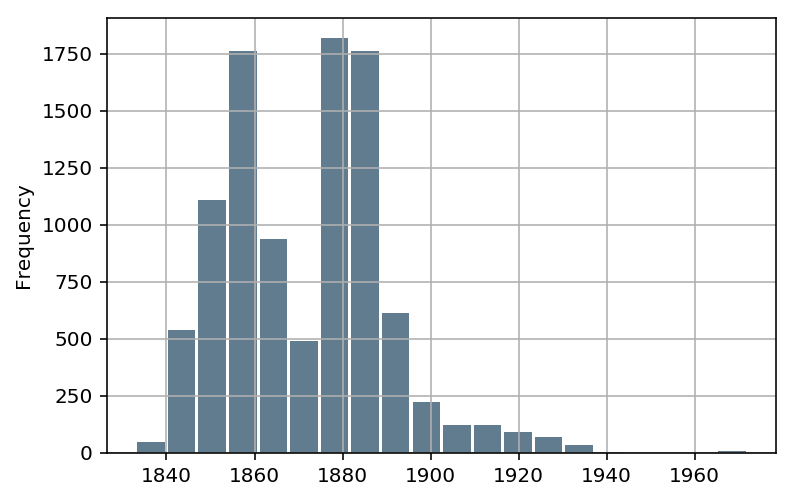

In [9]:
met_df['object_begin_date'].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')

Run: when-dat-photo-v1-resnet-101-i64-b256-e50-l2-w-pt-r200-v0.33


epoch,train_loss,valid_loss
1,7.478137,7.301330
2,7.222952,6.825524
3,6.724399,5.472190
4,5.479309,1.654007
5,3.934611,1.700012
6,2.860671,0.888723
7,2.057074,0.332504
8,1.526605,1.064433
9,1.219781,0.459381
10,1.041506,0.462148


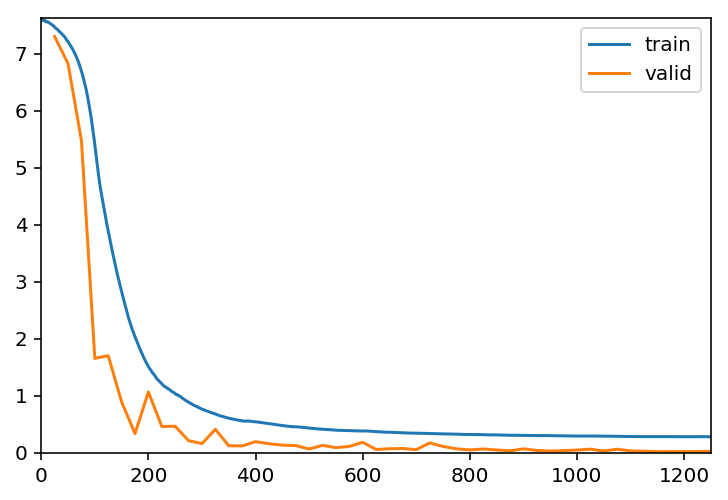

Run: when-dat-photo-v1-resnet-101-i64-b256-e50-l1-w-pt-r200-v0.33


epoch,train_loss,valid_loss
1,5.482307,1.961146
2,3.359463,1.520493
3,2.320877,13.592711
4,1.651277,0.953504
5,1.277424,0.700123
6,1.132552,8.518914
7,1.008863,5.171240
8,0.859161,0.457267
9,0.705017,0.402691
10,0.620511,0.431223


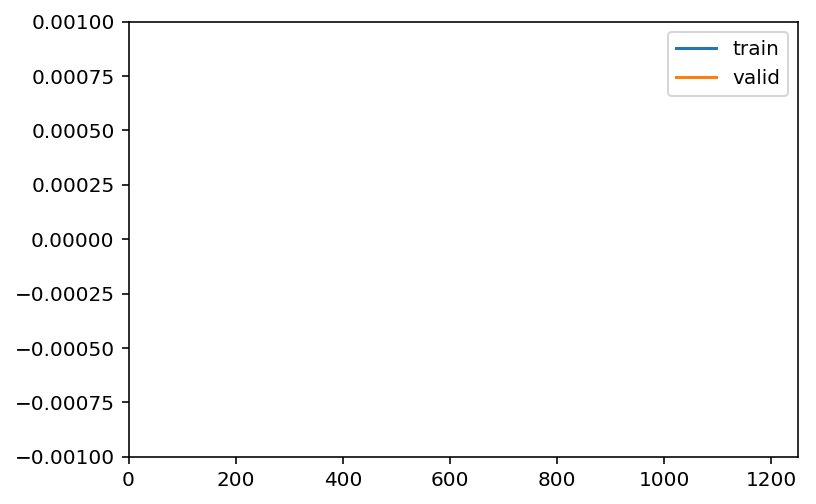

Run: when-dat-photo-v1-resnet-101-i64-b256-e100-l2-w-pt-r200-v0.33


epoch,train_loss,valid_loss
1,7.465825,7.173295
2,7.274503,6.855426
3,6.987338,6.315938
4,6.517924,5.267033
5,5.667389,3.352150
6,4.271695,1.171959
7,3.246328,0.949960
8,2.456721,0.634134
9,1.879572,0.357736
10,1.460603,0.901929


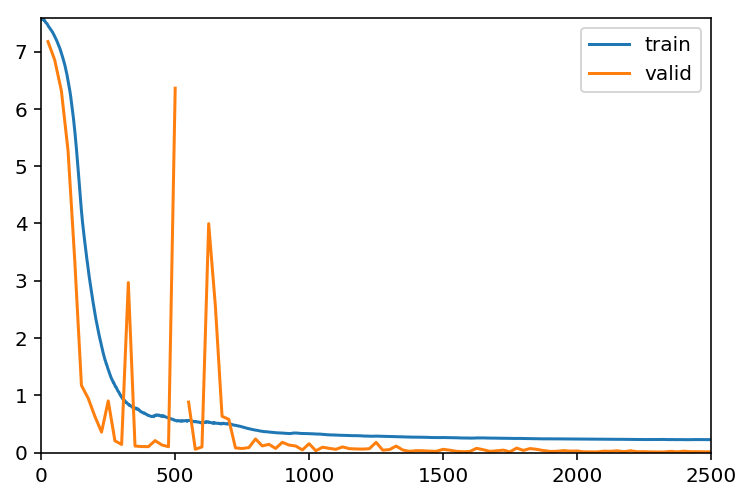

Run: when-dat-photo-v1-resnet-101-i64-b256-e100-l1-w-pt-r200-v0.33


epoch,train_loss,valid_loss
1,5.639704,2.427056
2,3.411308,0.777664
3,2.355937,0.852380
4,1.674028,0.310871
5,1.237098,0.326471
6,0.980222,0.114191
7,0.835213,0.258636
8,0.728411,0.102779
9,0.682545,0.315192
10,0.646773,0.119614


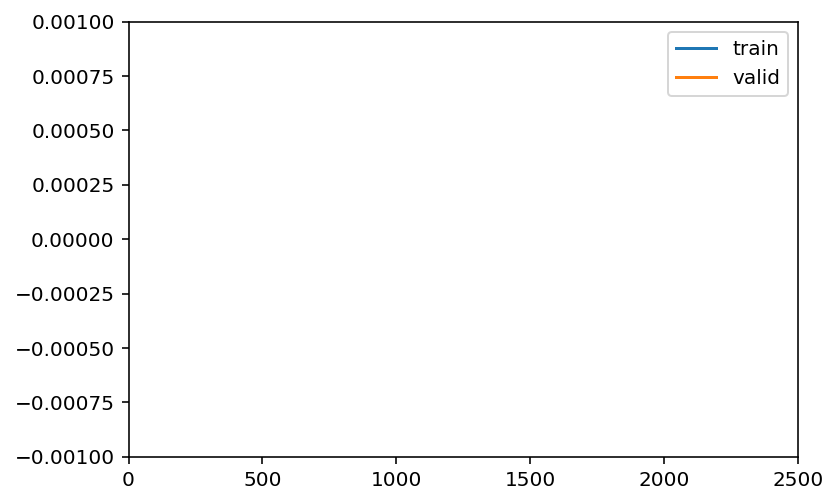

Run: when-dat-photo-v1-resnet-101-i128-b128-e50-l2-w-pt-r200-v0.33


epoch,train_loss,valid_loss
1,7.271715,6.822614
2,6.567455,5.604701
3,4.477762,0.975034
4,2.624510,1.119718
5,1.566478,0.865526
6,1.095567,0.961372
7,0.857898,0.135922
8,0.767798,0.170576
9,0.688296,0.187971
10,0.627311,1.570833


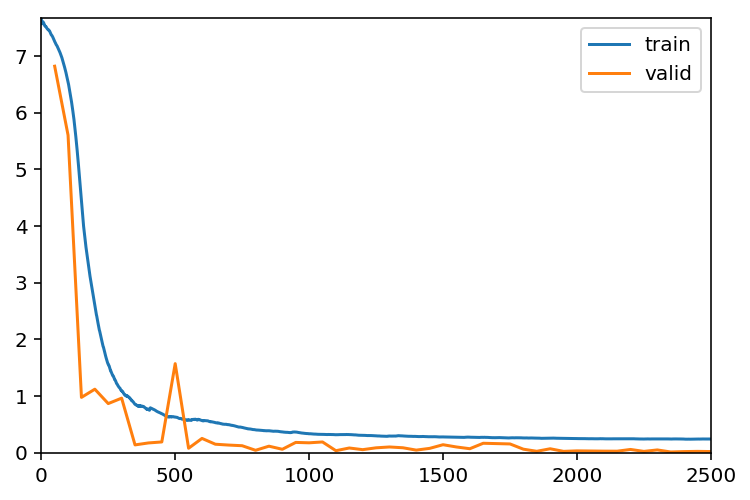

Run: when-dat-photo-v1-resnet-101-i128-b128-e50-l1-w-pt-r200-v0.33


epoch,train_loss,valid_loss
1,3.340019,0.935138
2,1.651068,0.251886
3,0.953035,0.202136
4,0.670998,0.164510
5,0.533100,0.283053
6,0.478577,0.246311
7,0.432601,0.342183
8,0.528510,0.555388
9,0.590526,0.294693
10,0.638213,0.719766


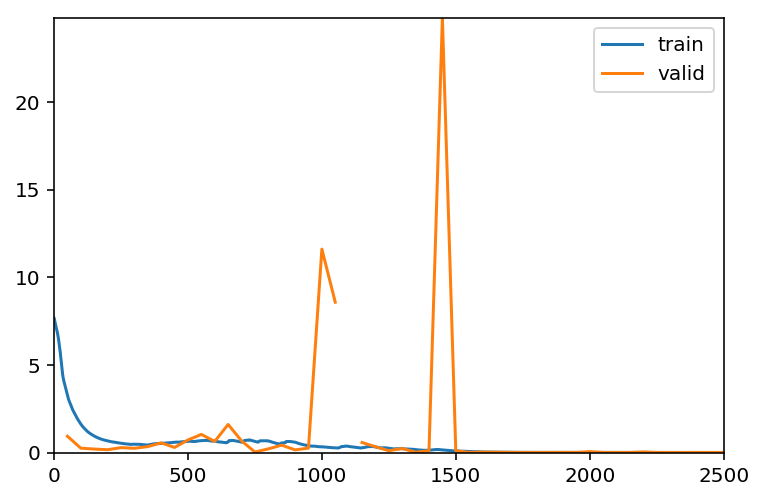

Run: when-dat-photo-v1-resnet-101-i128-b128-e100-l2-w-pt-r200-v0.33


epoch,train_loss,valid_loss
1,7.293413,6.953261
2,6.735355,6.037251
3,5.654959,4.140300
4,3.677987,0.917513
5,2.369663,1.523172
6,1.646977,1.409175
7,1.211832,0.439463
8,0.957785,0.255623
9,0.838481,0.347495
10,0.738955,0.210854


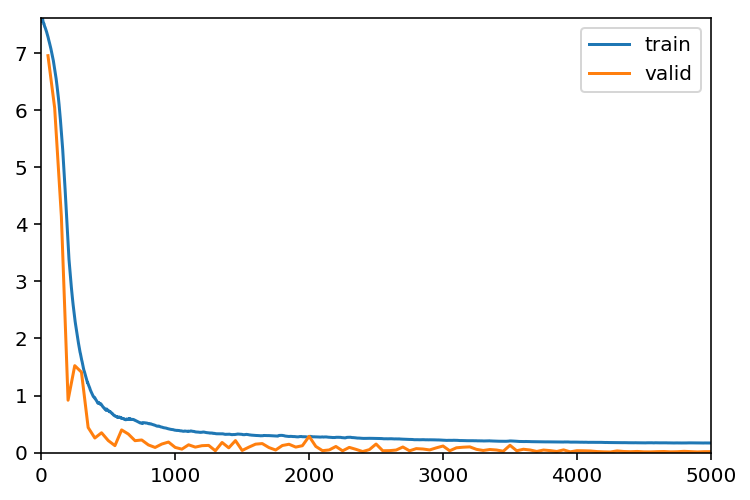

Run: when-dat-photo-v1-resnet-101-i128-b128-e100-l1-w-pt-r200-v0.33


epoch,train_loss,valid_loss
1,3.428085,1.364336
2,1.745464,0.388347
3,1.015357,0.648499
4,0.707381,0.220711
5,0.579593,0.163428
6,0.505070,0.177653
7,0.460259,0.120490
8,0.417419,0.240157
9,0.392102,0.152839
10,0.364885,0.157116


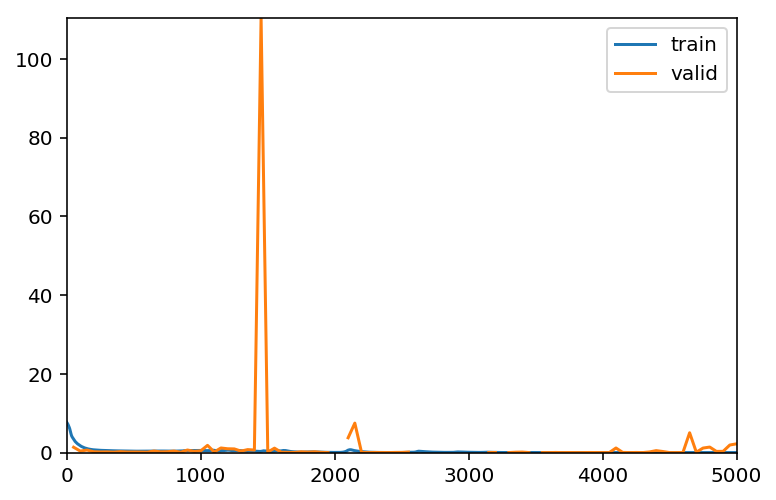

Run: when-dat-photo-v1-resnet-101-i256-b64-e50-l2-w-pt-r200-v0.33


epoch,train_loss,valid_loss
1,6.730224,6.077287
2,3.798218,1.089609
3,1.682448,0.746039
4,0.942563,0.257119
5,0.662750,0.268568
6,0.554937,0.141905
7,0.510212,0.148009
8,0.474346,0.292999
9,0.448482,0.077527
10,0.416936,0.246932


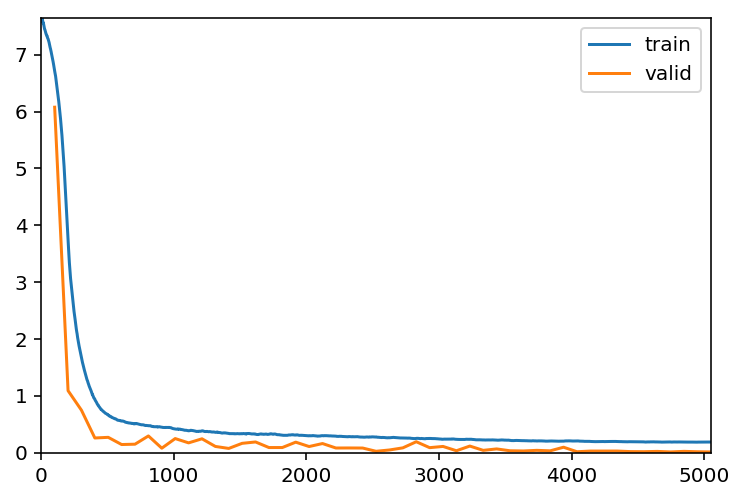

RuntimeError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 1; 7.77 GiB total capacity; 5.42 GiB already allocated; 55.50 MiB free; 208.79 MiB cached)

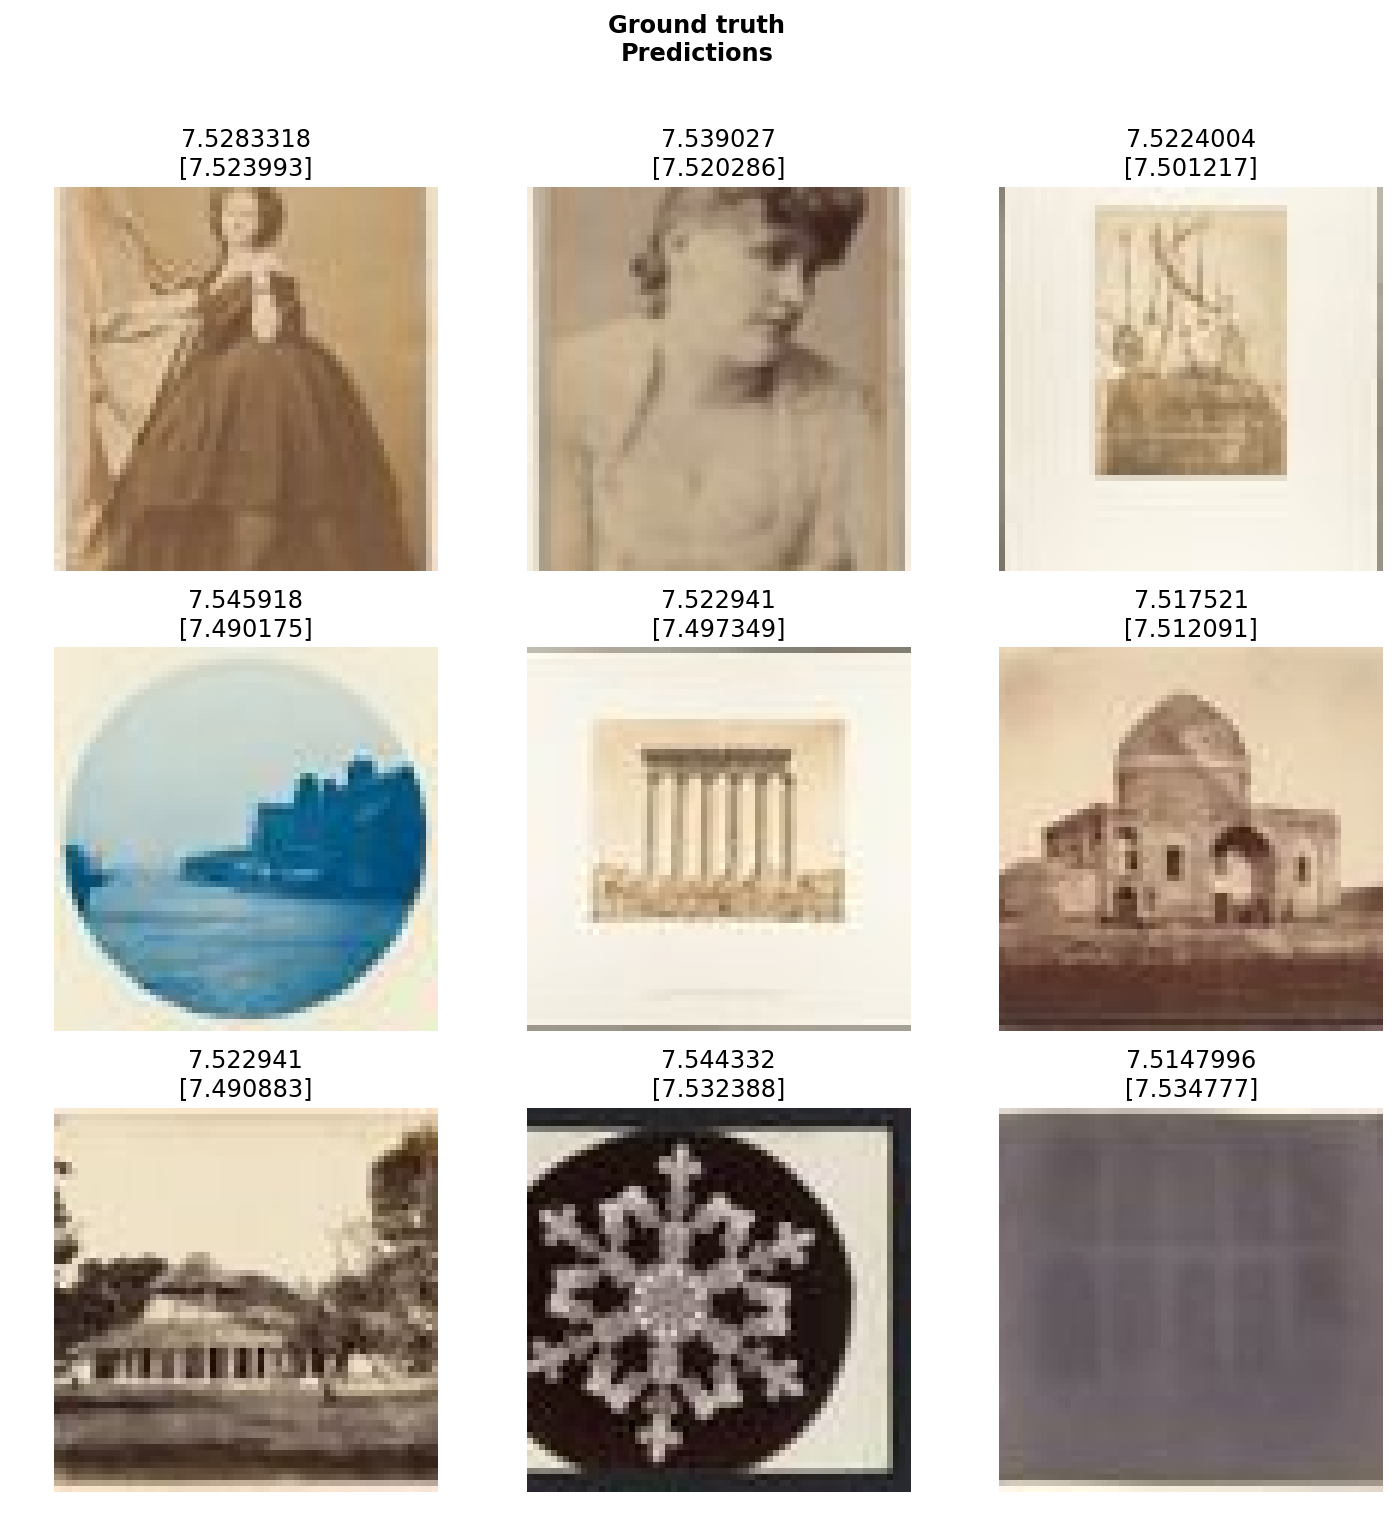

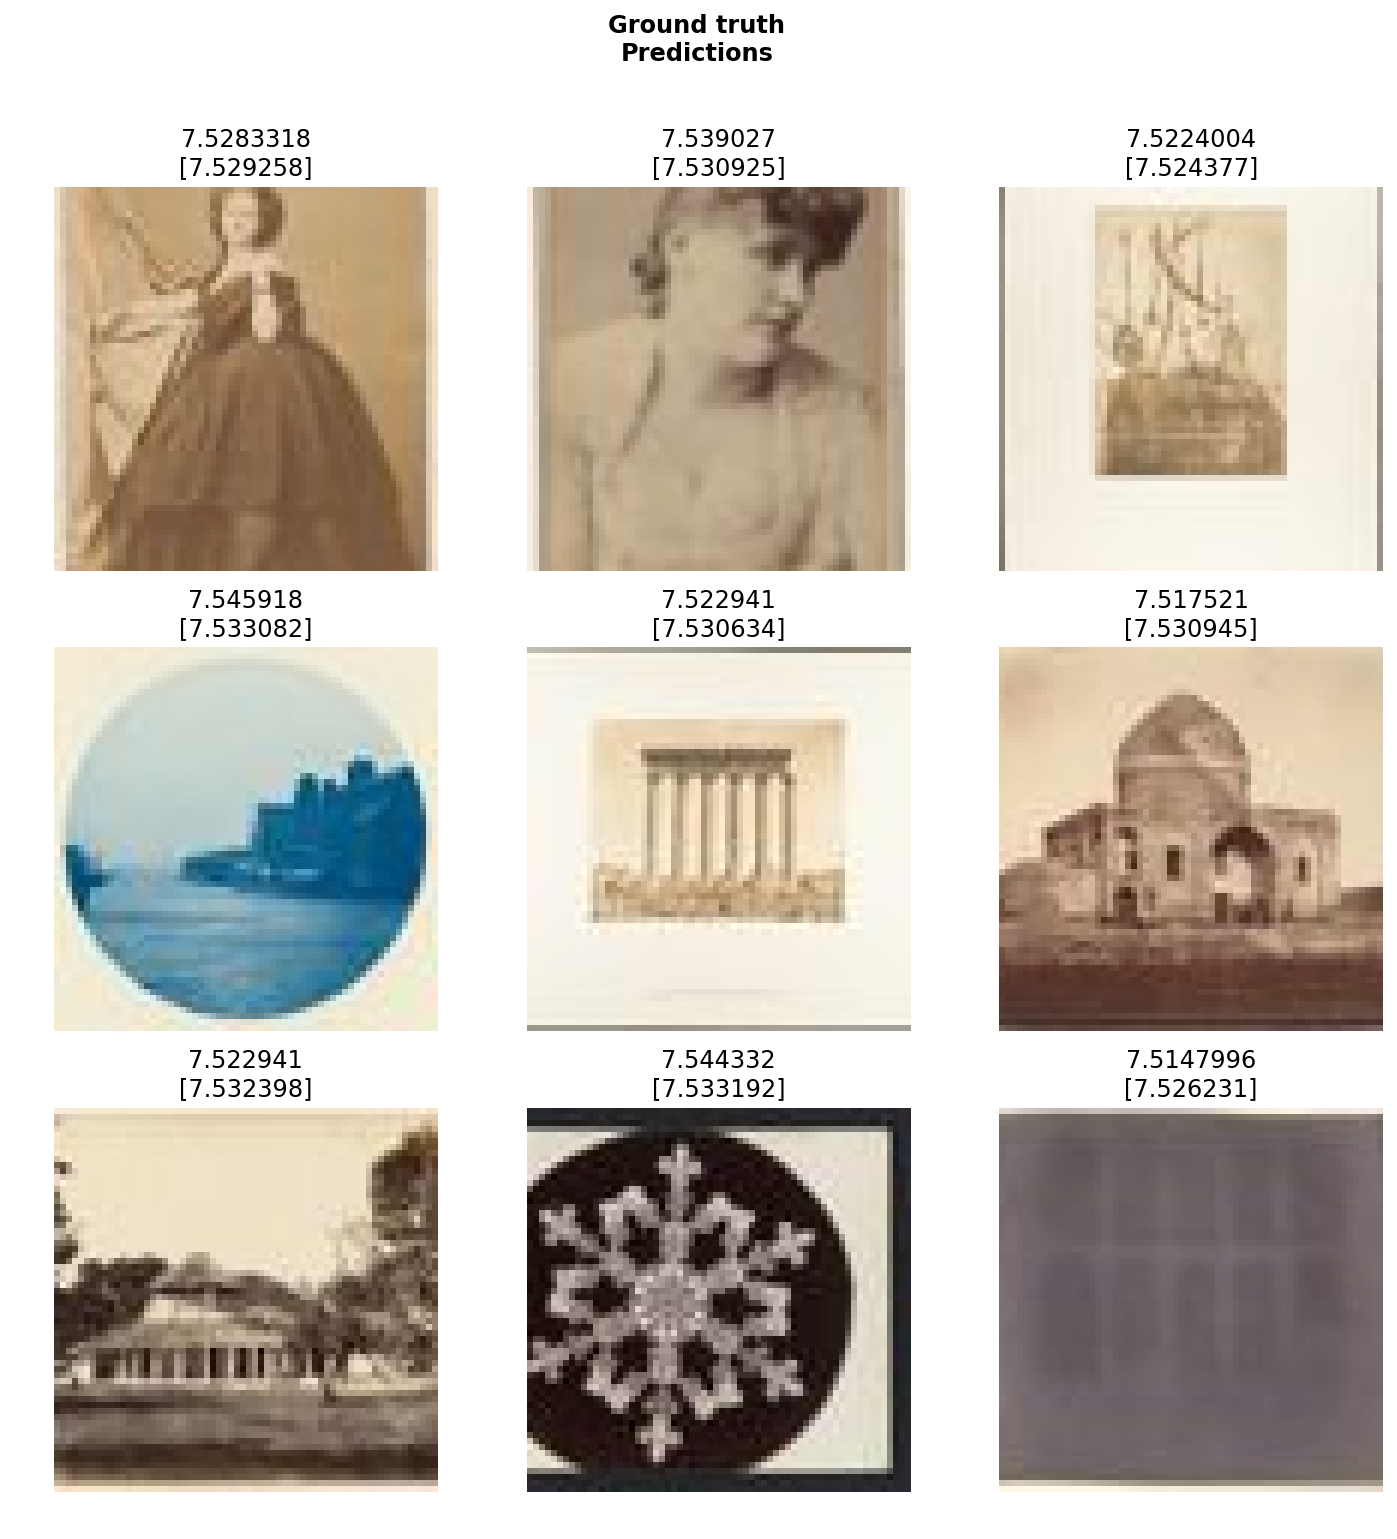

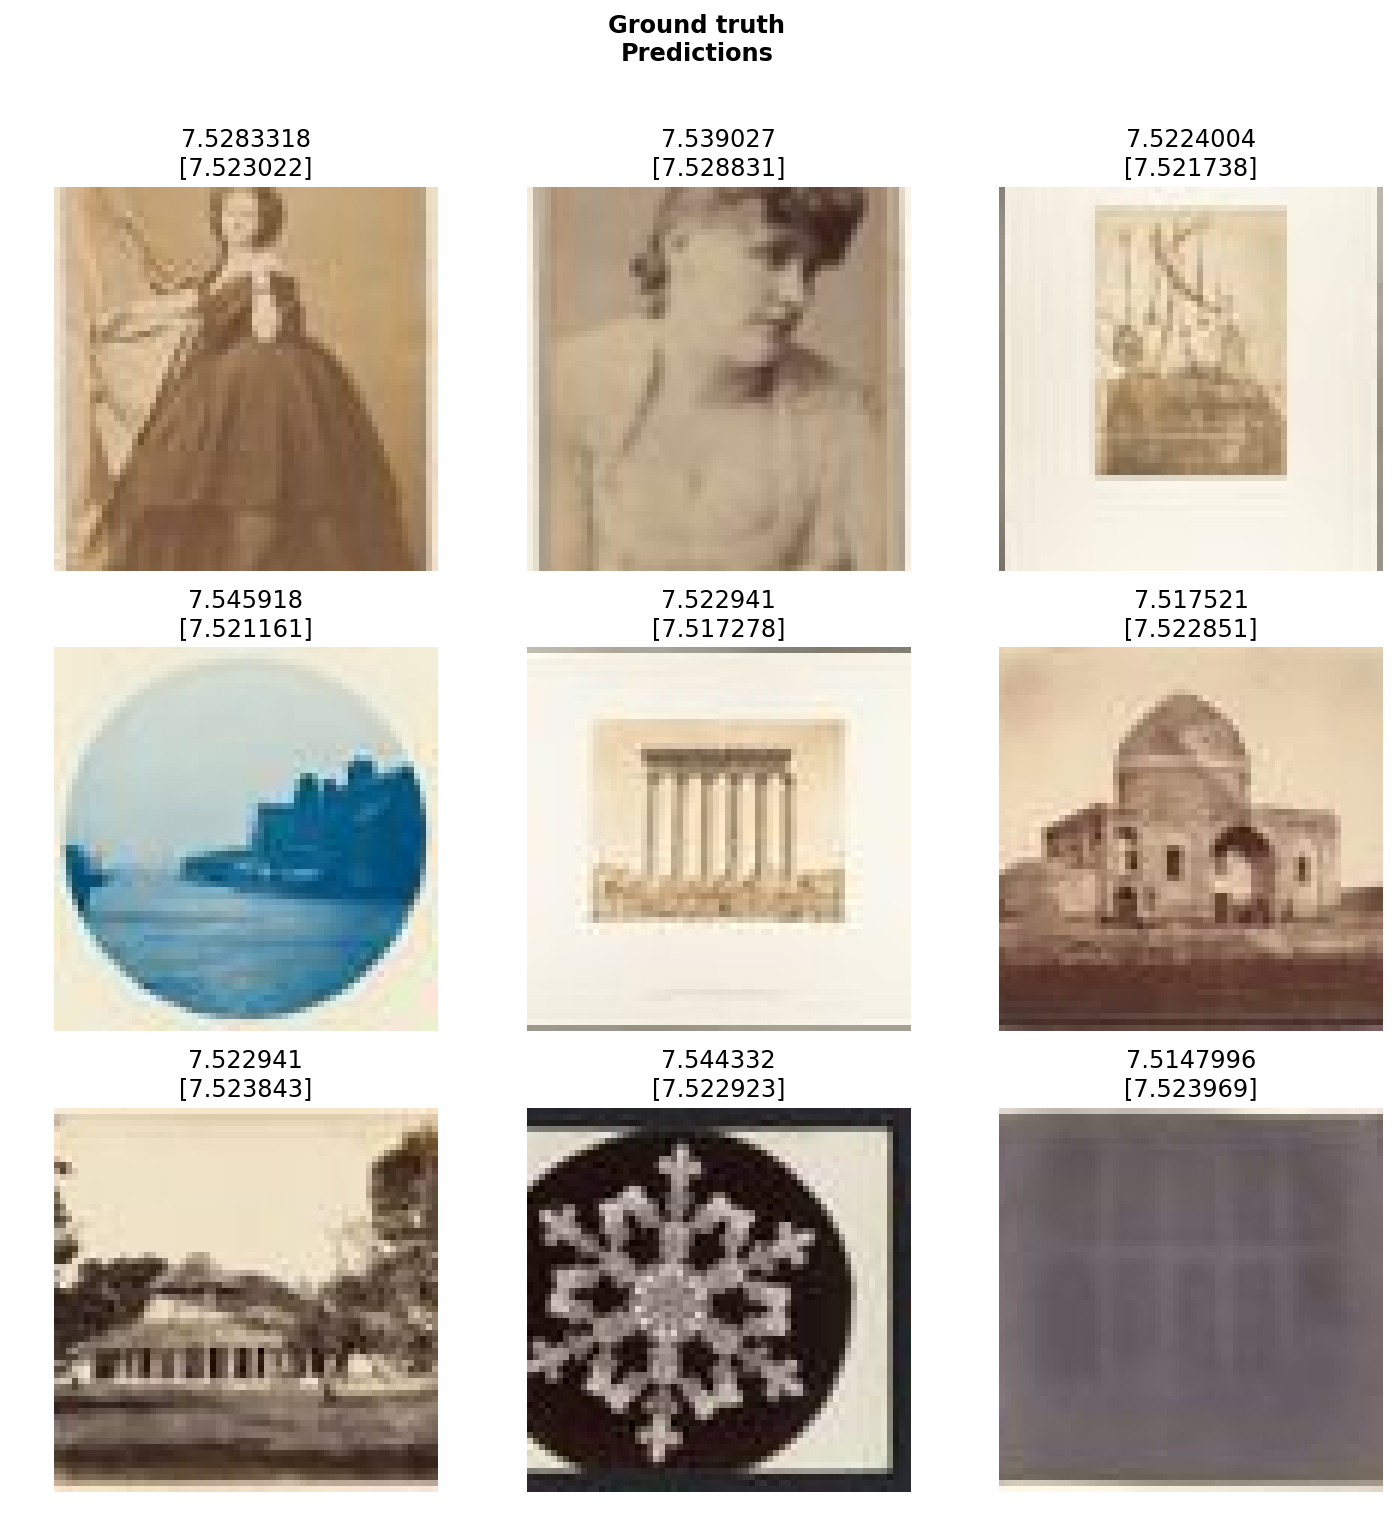

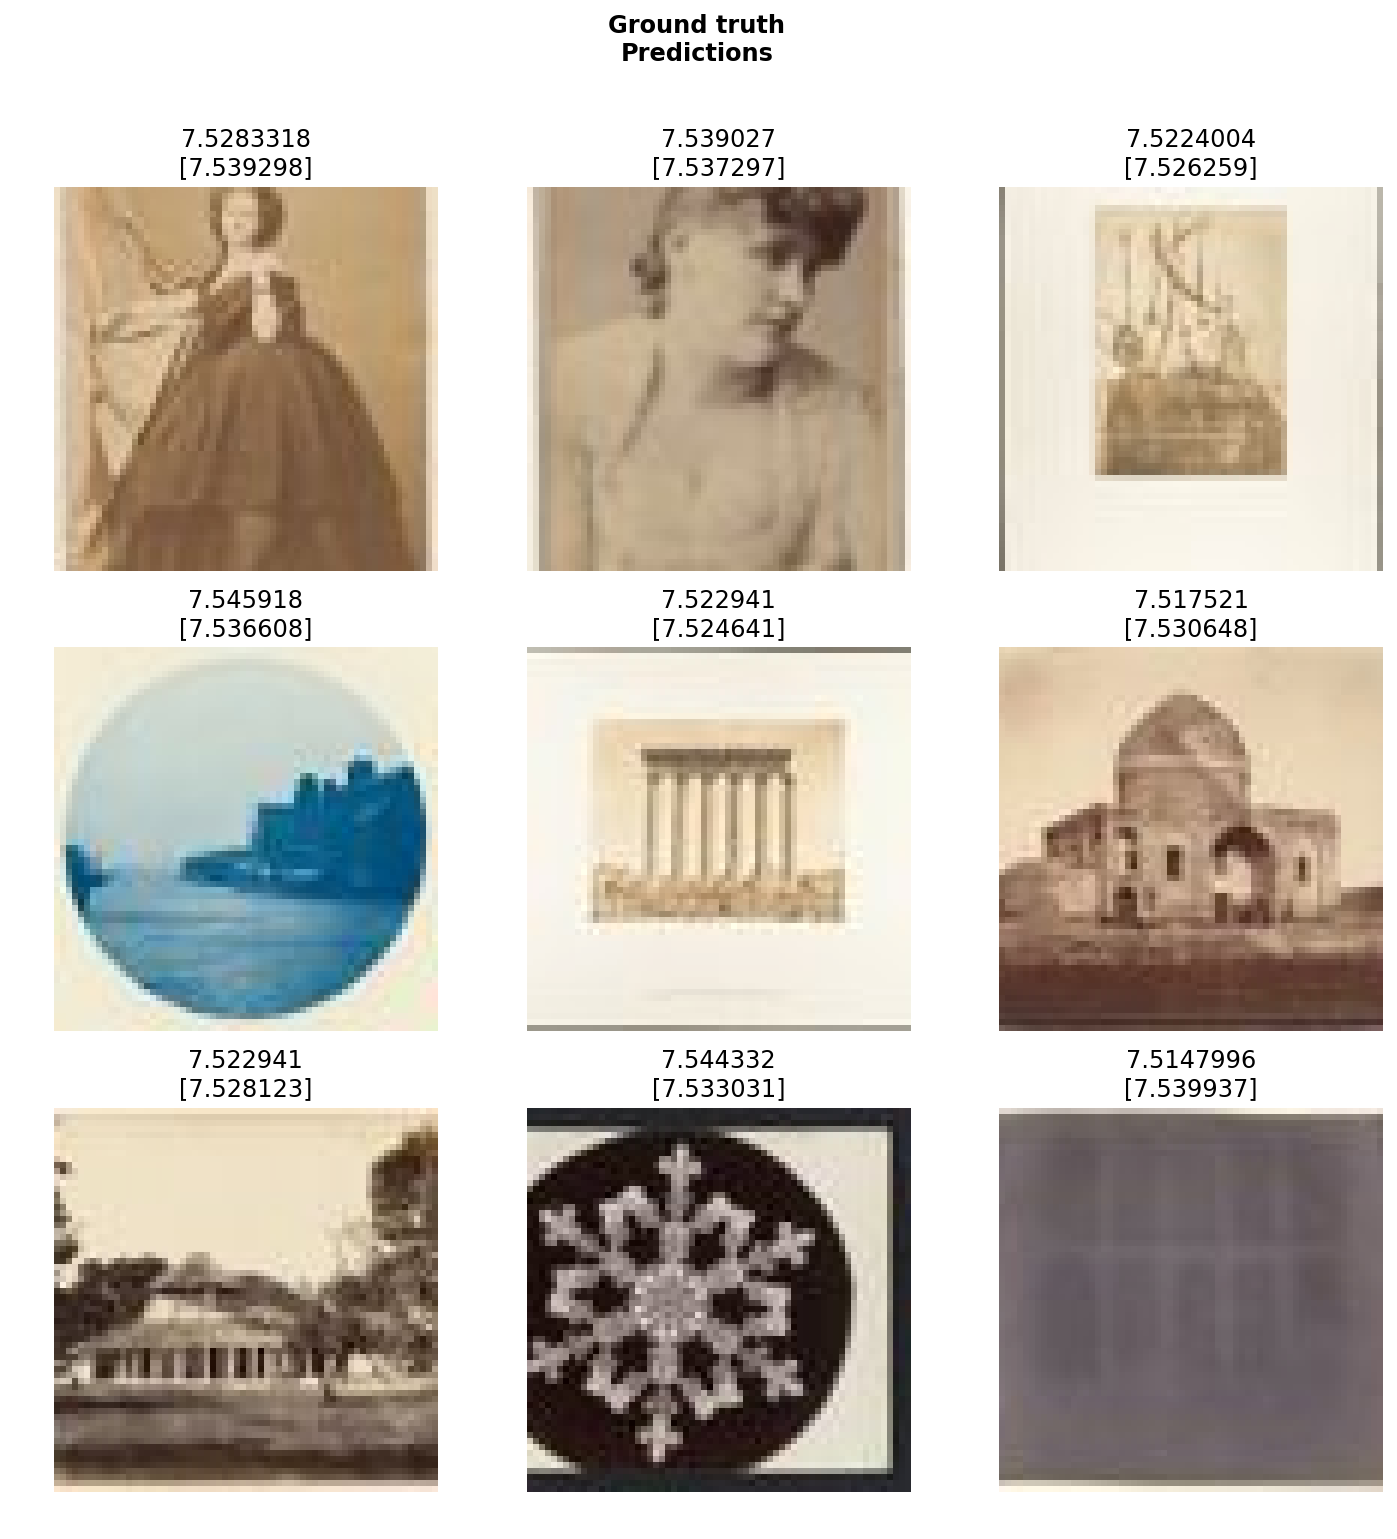

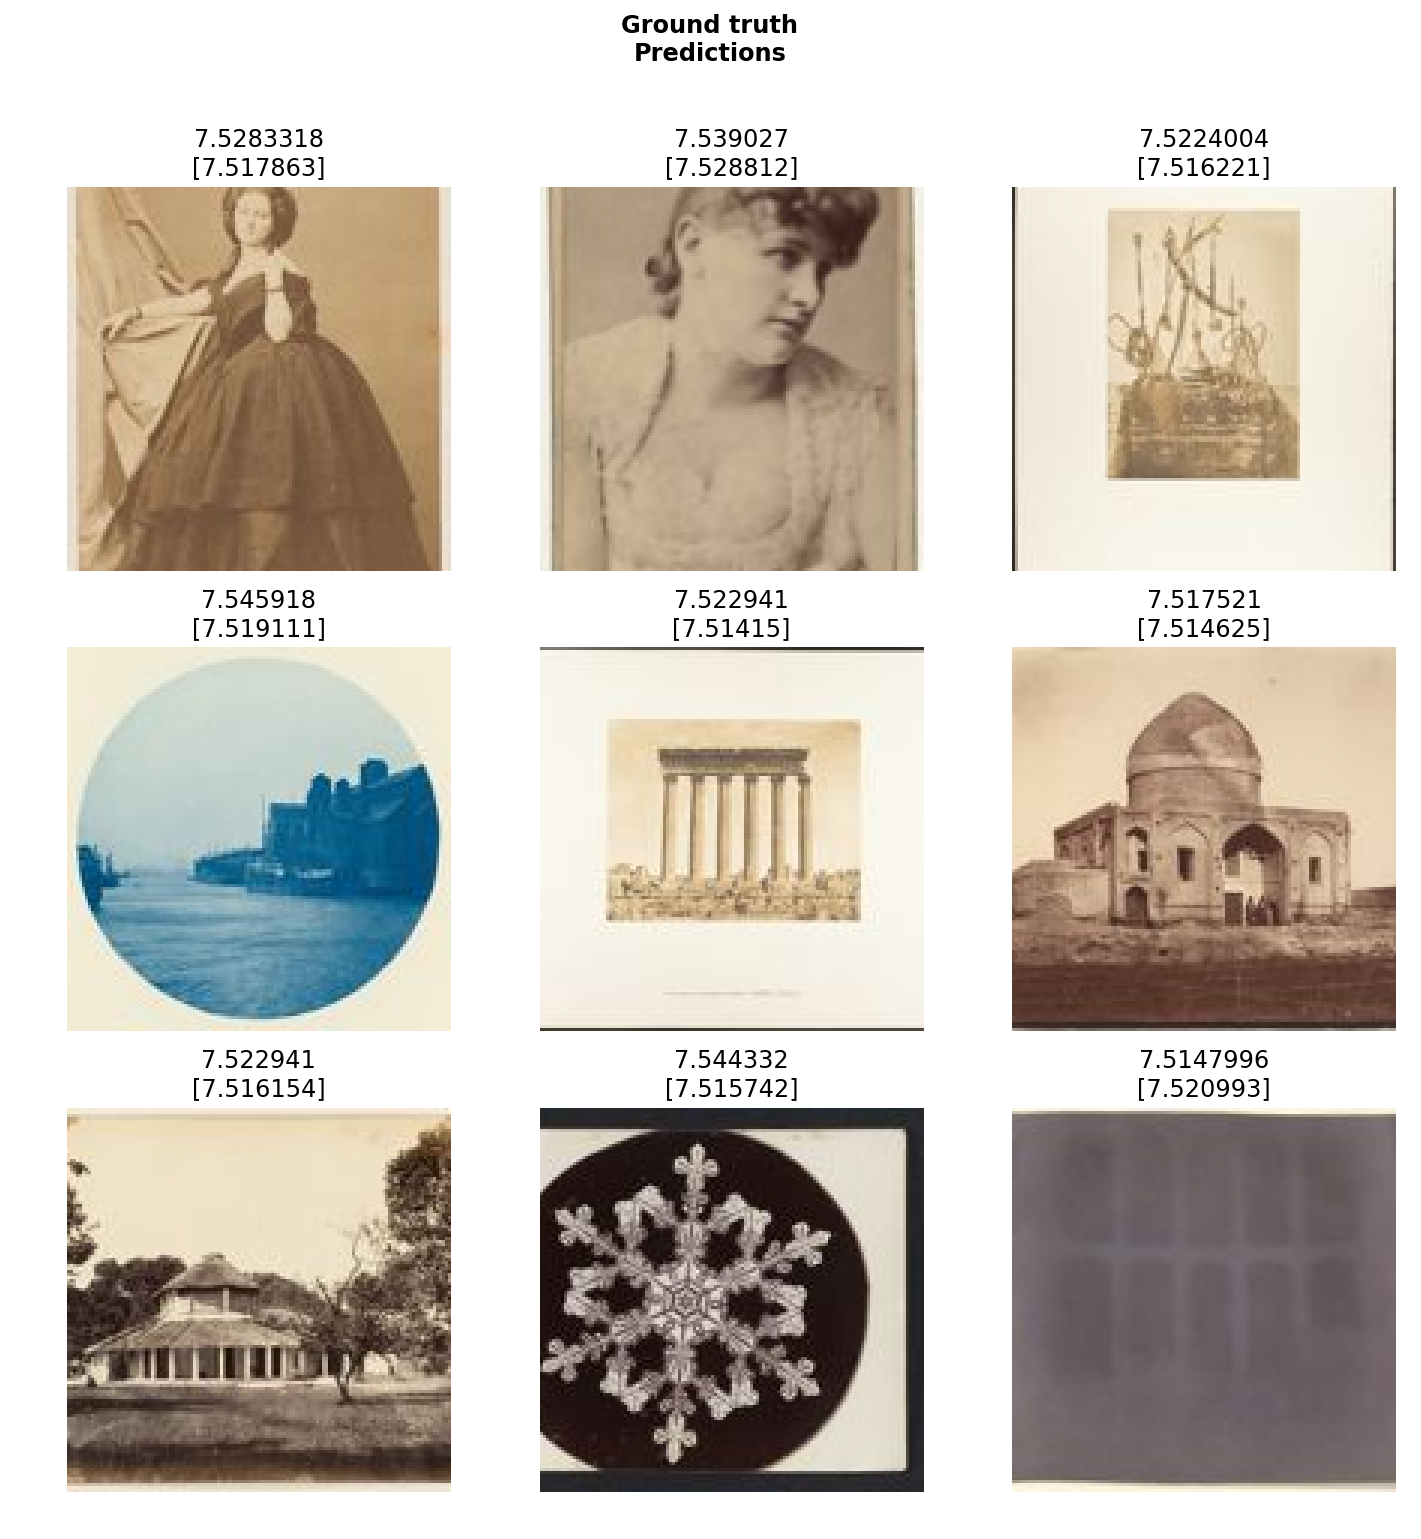

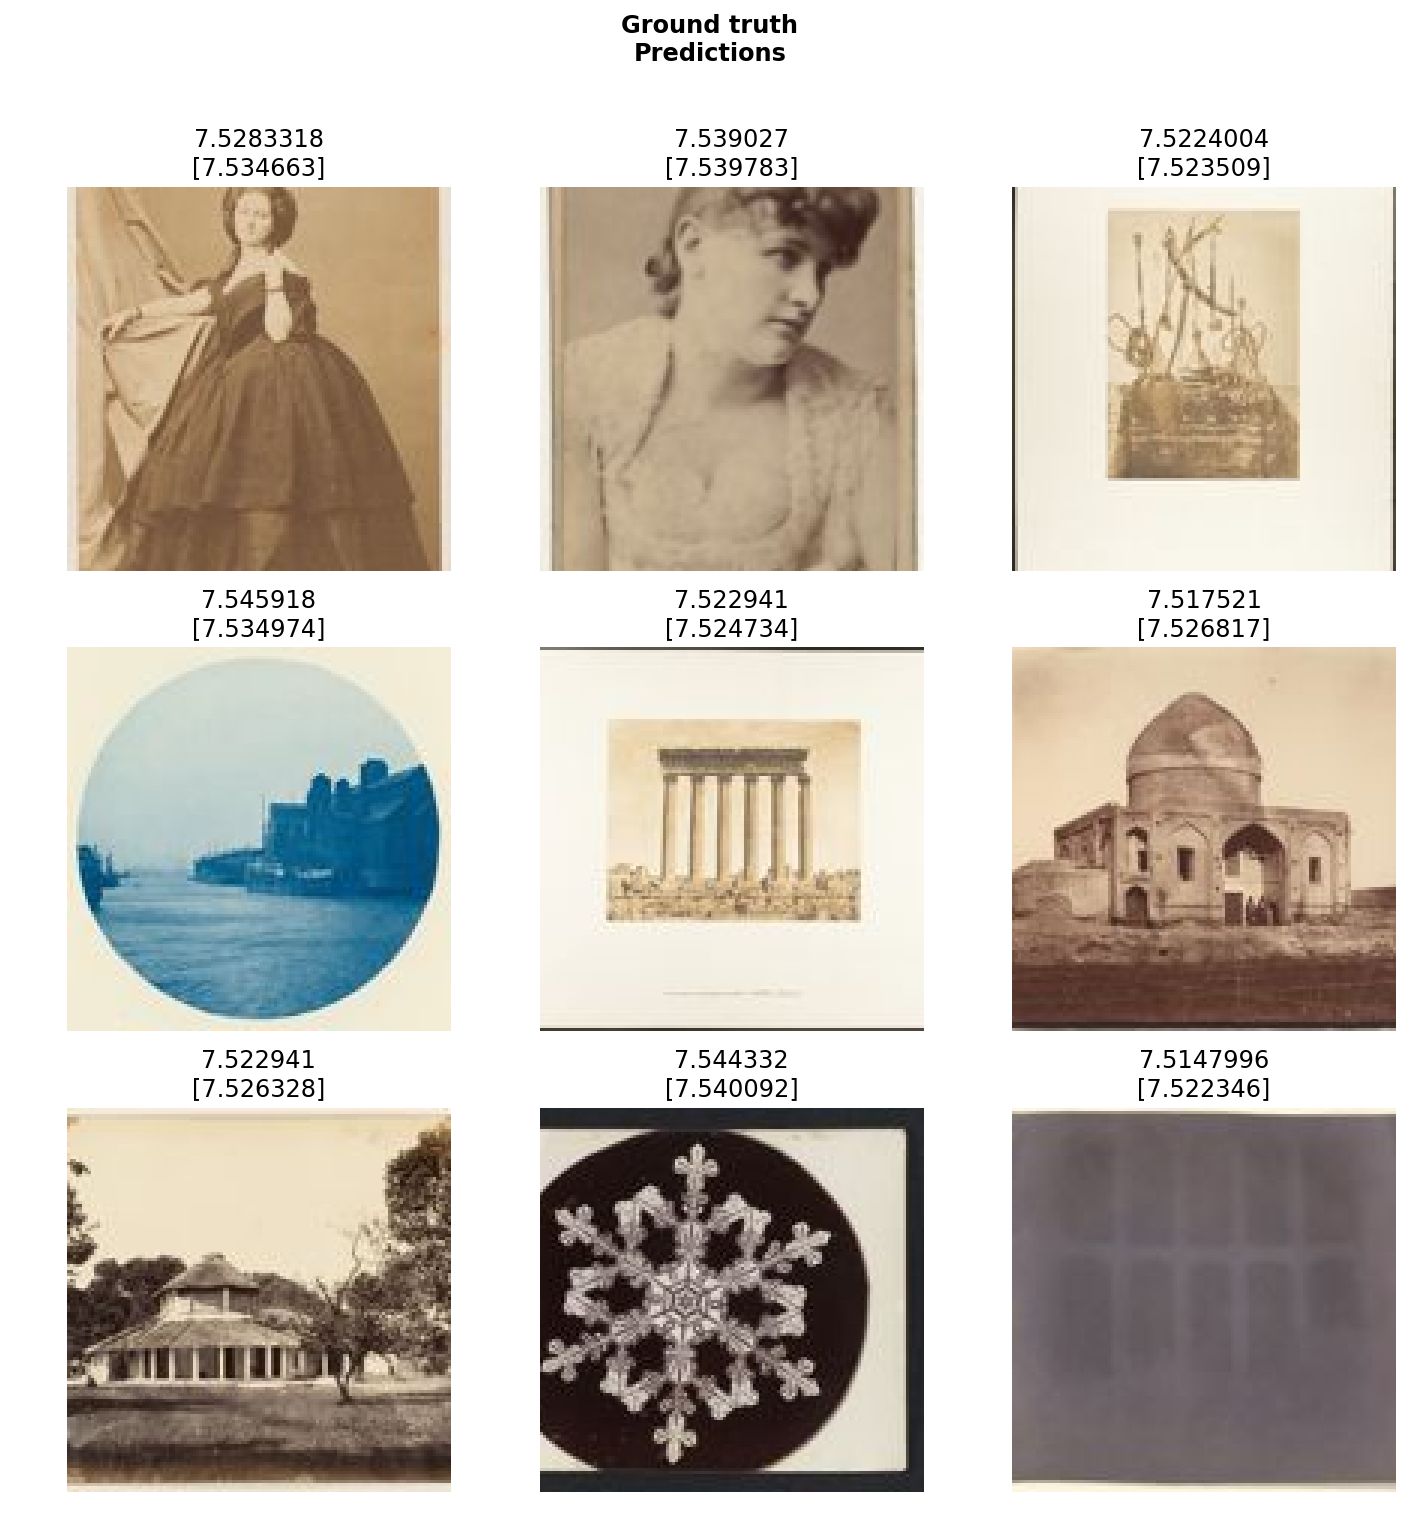

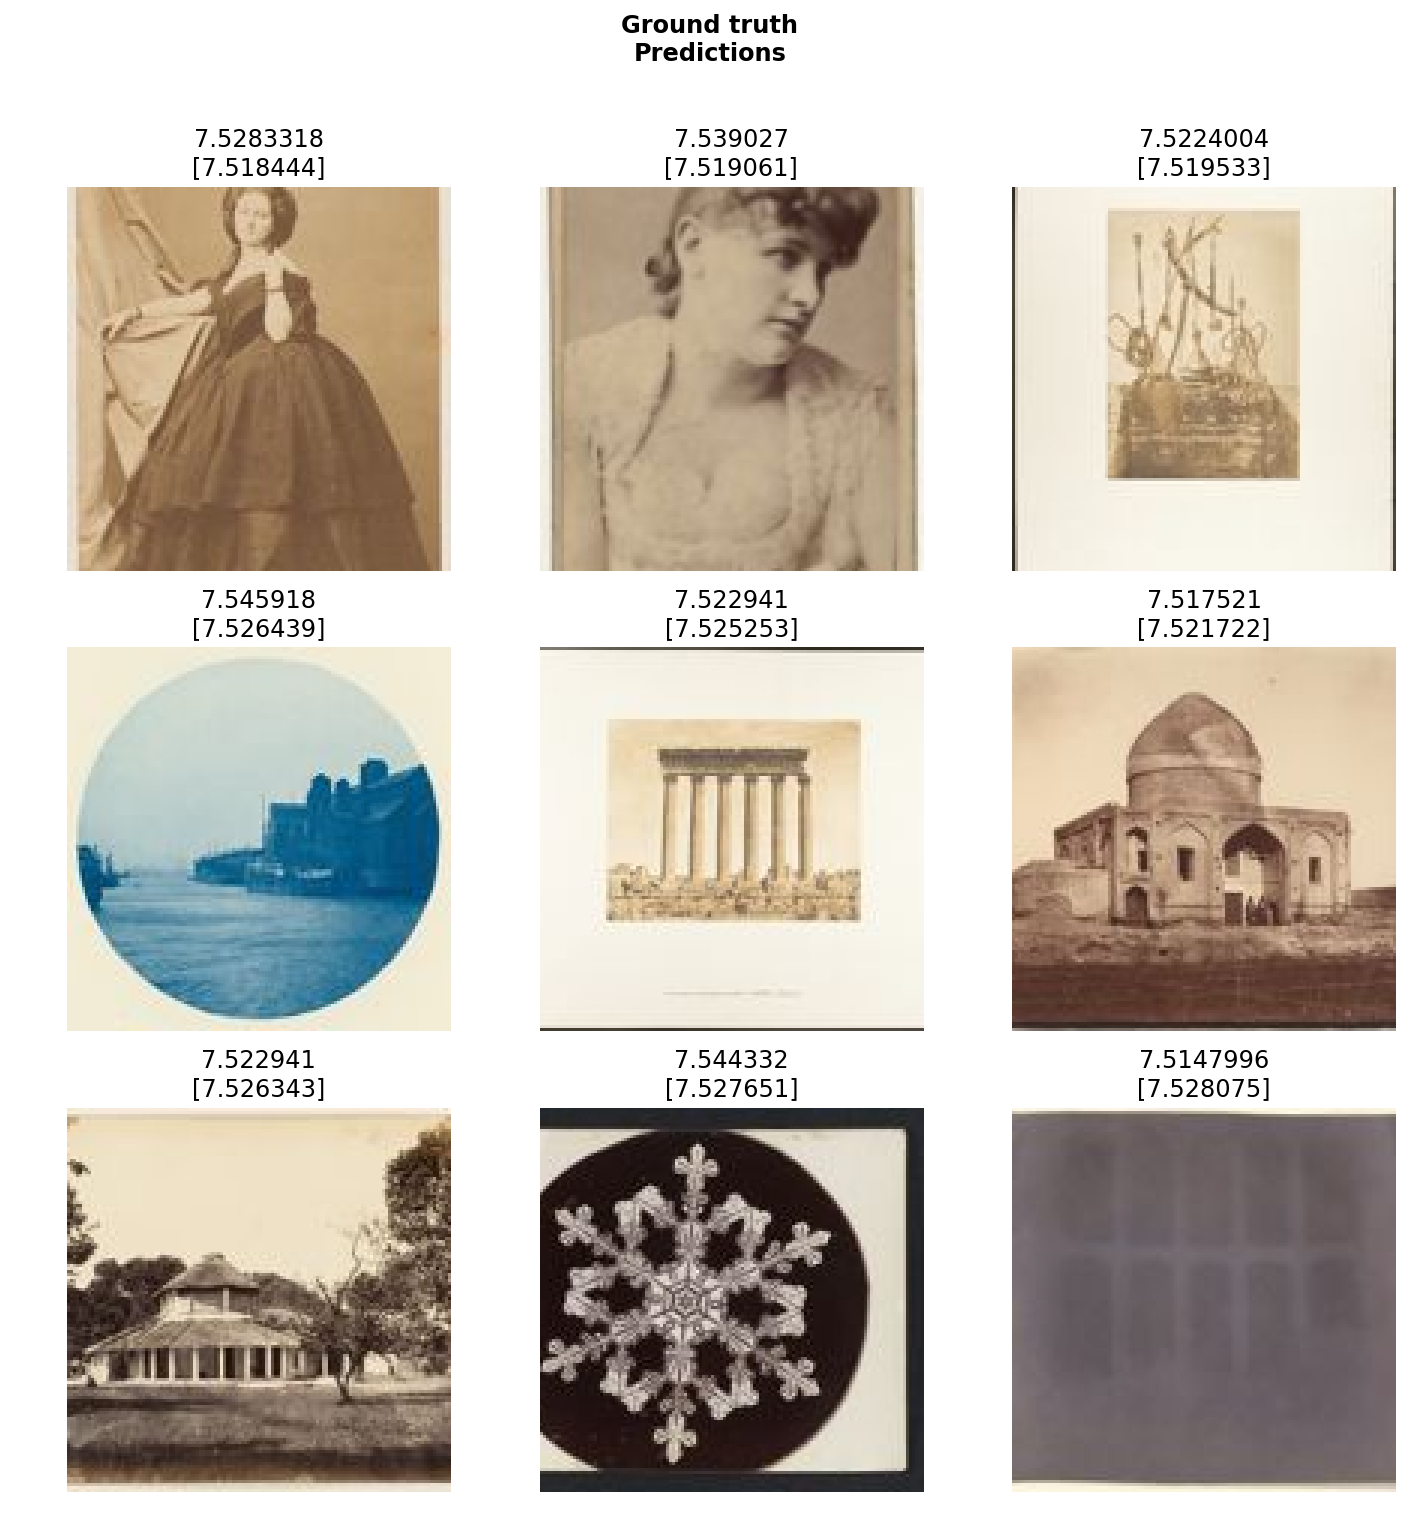

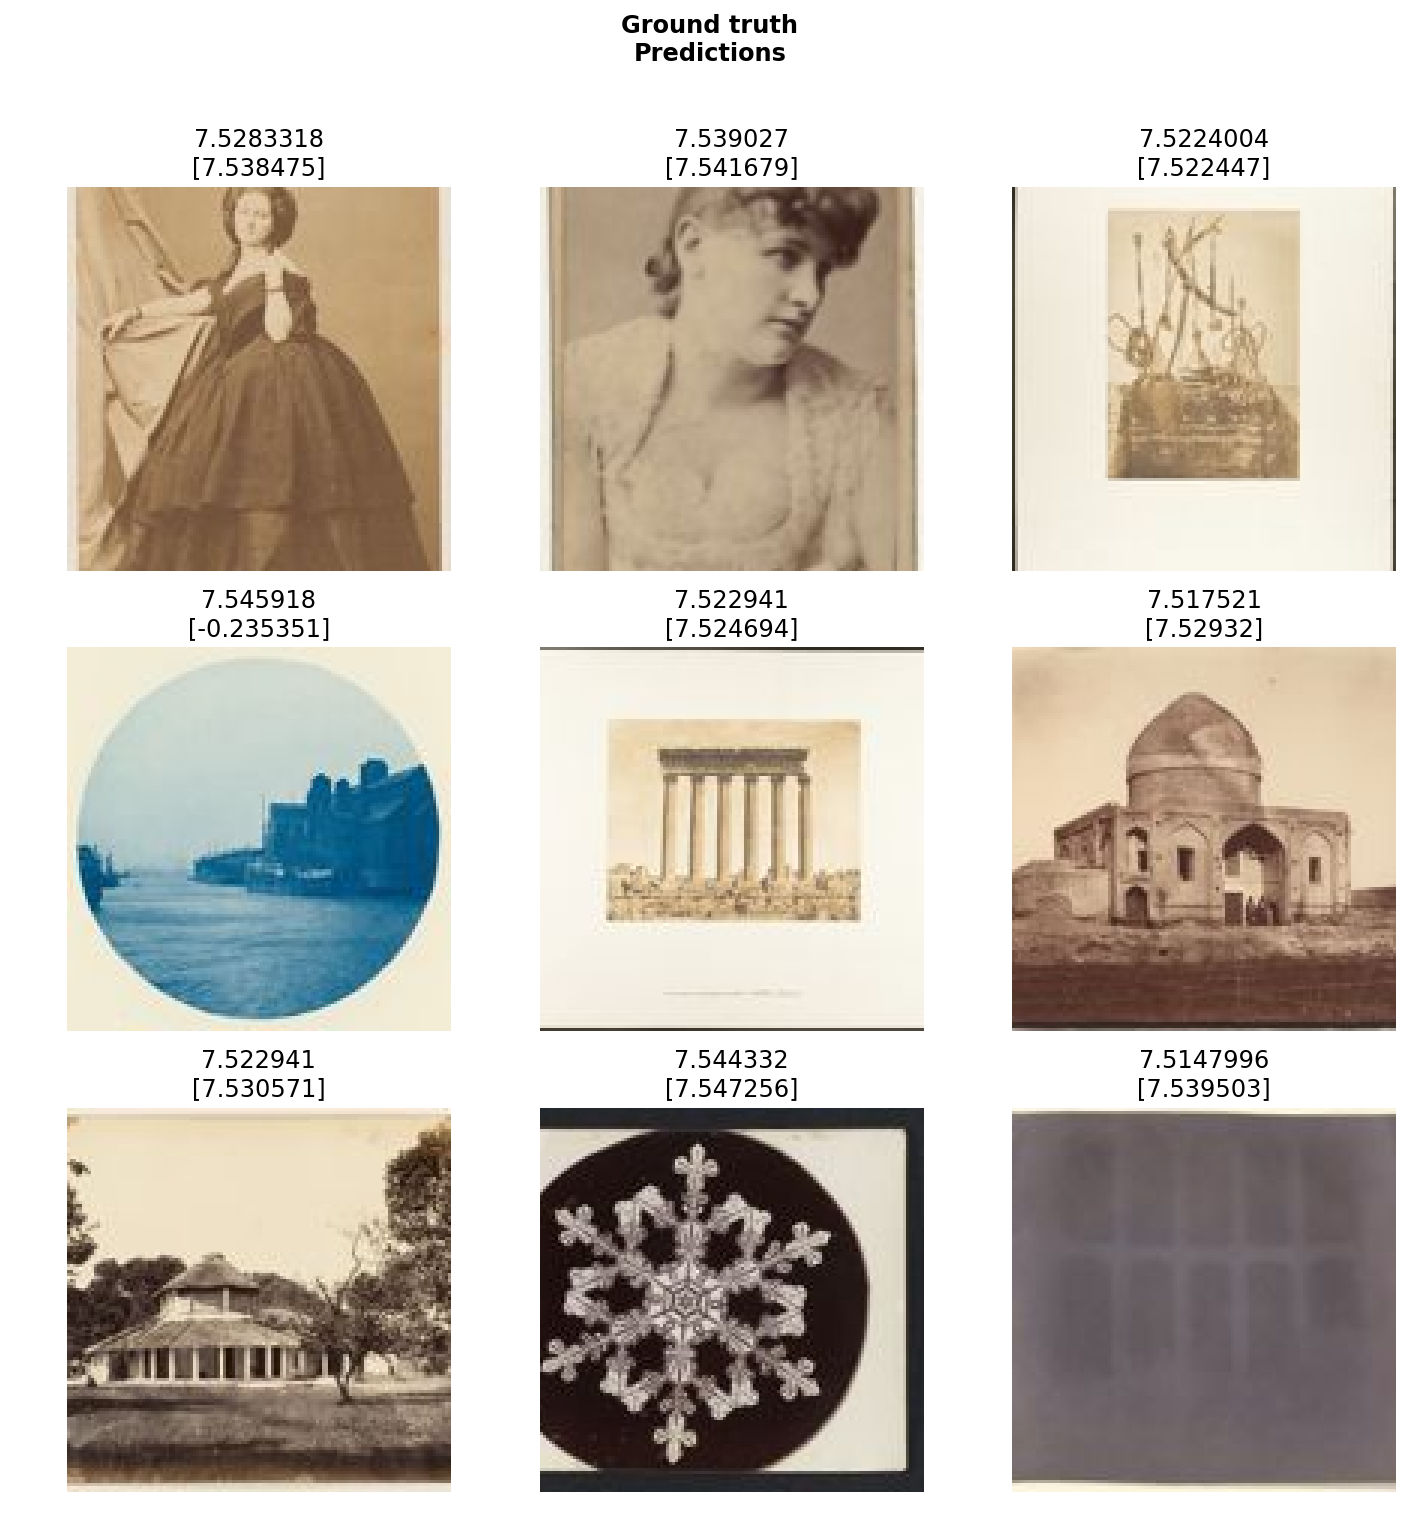

In [6]:
testing_models = [(models.resnet101, 'resnet-101')] # (models.resnet34, 'resnet-34'), (models.resnet50, 'resnet-50')

image_and_batch_sizes = [(64, 256), (128, 128), (256,64)]
epochs = [50,100]
learning_rates = [(1e-2, '2'), (1e-1, '1')]
pretraineds = [(True, 'w-pt')] # , (False, 'no-pt')]
random_seeds = [200]
validation_percents = [0.33]

photo_tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.1, max_warp=0.2, max_rotate=20.0)
successful_runs = []

for model, image_and_batch_size, epoch, learning_rate, pretrained, random_seed, validation_percent in [( model, image_and_batch_size, epoch, learning_rate, pretrained, random_seed, validation_percent) for model in testing_models for image_and_batch_size in image_and_batch_sizes for epoch in epochs for learning_rate in learning_rates for pretrained in pretraineds for random_seed in random_seeds for validation_percent in validation_percents]:
    image_size = image_and_batch_size[0]
    batch_size = image_and_batch_size[1]
    run_name = f'when-dat-photo-v1-{model[1]}-i{image_size}-b{batch_size}-e{epoch}-l{learning_rate[1]}-{pretrained[1]}-r{random_seed}-v{validation_percent}'
    print(f'Run: {run_name}')
    torch.cuda.empty_cache()
    fastai_image_databunch = (ImageItemList.from_df(df=met_df, path='/data/kaggle/met/', folder=f'tmp/{image_size}', cols='image_path')
                     .random_split_by_pct(valid_pct=validation_percent, seed=random_seed)
                     .label_from_df(cols='object_begin_date', label_cls=FloatList, log=True)
                     .transform(photo_tfms, size=image_size)
                     .databunch(bs=batch_size))
    learn = create_cnn(fastai_image_databunch, model[0], callback_fns=ShowGraph, pretrained=pretrained[0], loss_func=root_mean_squared_error).to_fp16()
    learn.fit_one_cycle(epoch, learning_rate[0])
    successful_runs.append(run_name)
    learn.save(run_name)
    learn32 = learn.to_fp32()
    learn32.show_results(rows=3)